In [24]:
%load_ext autoreload
%autoreload 2
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 

import numpy as np
import matplotlib.pyplot as plt
from hhl_algorithm_ import HHLAlgorithm as hhl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
dz = 20 #mm

n_particles=[2]#0, 20, 20, 20]
events = len(n_particles)
layers = 3

n = np.sum(n_particles)

module_id = [l for l in range(1, layers+1)]
lx = [33 for x in range(1, layers+1)]
ly = [33 for x in range(1, layers+1)]
zs = [dz*l for l in range(1, layers+1)]

Detector = state_event_model.PlaneGeometry(module_id=module_id,lx = lx,ly = ly,z = zs)
# Detector = state_event_model.RectangularVoidGeometry(module_id=module_id,lx = lx,ly = ly,z=zs, void_x_boundary=5, void_y_boundary=5)

state_event_gen = StateEventGenerator(Detector, events = len(n_particles), n_particles=n_particles)#,
                                       #measurement_error=0.00, collision_noise=0.000)
state_event_gen.generate_random_primary_vertices(events, {'x': 0, 'y': 0, 'z': 0})

[(0, 0, 0.0)]

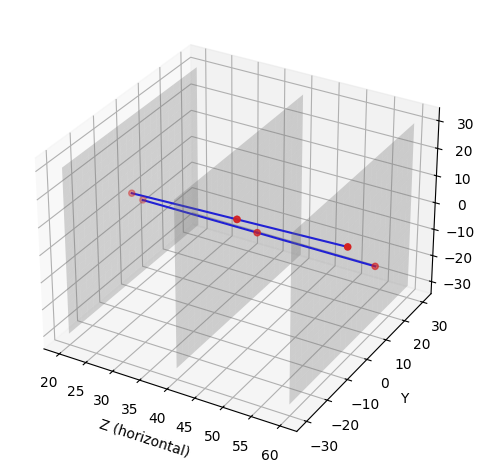

In [26]:
event_particles = []
for event in range(events):
    particles_list = []
    for particle in range(n):
        particle_dict = {
            'type' : 'MIP',
            'mass': 0.511,
            'q': 1
        }
        particles_list.append(particle_dict)
    event_particles.append(particles_list)

state_event_gen.generate_particles(event_particles)

event_tracks = state_event_gen.generate_complete_events()

event_tracks.plot_segments()

In [27]:
false_tracks = state_event_gen.make_noisy_event(drop_rate=0.0, ghost_rate=0.0)

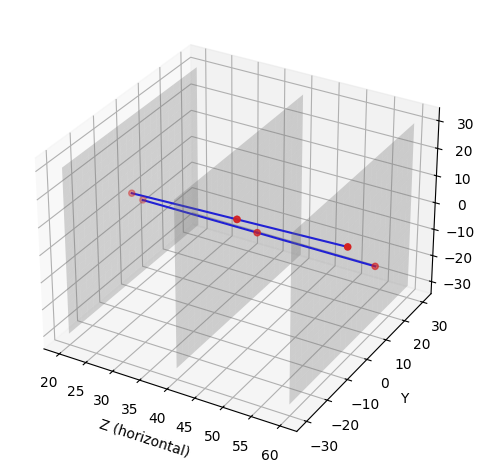

In [28]:
false_tracks.plot_segments()

In [29]:
print(len(false_tracks.modules[0].hits))
print(len(event_tracks.modules[0].hits))

2
2


In [30]:
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian

ham = SimpleHamiltonian(epsilon=1e-7, gamma=2.0, delta=1.0)

ham.construct_hamiltonian(event=event_tracks, convolution=True)
classical_solution = ham.solve_classicaly()
T = .45
discretized_classical_solution = (classical_solution > T).astype(int)
 

In [31]:
A = ham.A.todense()

In [35]:
print("HHL Algorithm Implementation")
print("=" * 60)

matrix_A = A
vector_b = np.ones(len(A))

print("\nSolving Ax = b with:")
print("A =")
print(matrix_A)
print("b =")
print(vector_b)

# Create an instance of the HHL algorithm.
hhl_solver = hhl(matrix_A, vector_b, num_time_qubits=len(A), shots=2048)
circuit = hhl_solver.build_circuit()
print("\nHHL Circuit:")
print(circuit.draw(output="text"))

# Run the circuit.
counts = hhl_solver.run()
print("\nRaw Measurement Counts:")
print(counts)

# # Plot the histogram of all measurement results.
# hhl_solver.plot_results("hhl_results.png")

# Extract the HHL solution (trimmed to the original dimension).
x_hhl = hhl_solver.get_solution()
print("\nExtracted HHL solution (normalized):")
print(x_hhl)

# Compute the theoretical solution for comparison (using the original system, not the padded one).
x_exact = np.linalg.solve(matrix_A, vector_b)
x_exact_normalized = x_exact / np.linalg.norm(x_exact)
print("\nTheoretical solution (normalized):")
print(x_exact_normalized)

HHL Algorithm Implementation

Solving Ax = b with:
A =
[[ 3.          0.          0.          0.         -0.79925964  0.
   0.          0.        ]
 [ 0.          3.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          3.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          3.          0.          0.
   0.         -0.86549552]
 [-0.79925964  0.          0.          0.          3.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          3.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   3.          0.        ]
 [ 0.          0.          0.         -0.86549552  0.          0.
   0.          3.        ]]
b =
[1. 1. 1. 1. 1. 1. 1. 1.]

HHL Circuit:
         »
 time_0: »
         »
 time_1: »
         »
 time_2: »
         »
 time_3: »
         »
 time_4: »
         »
 time_5: »
         »
 time_6: »
  

In [19]:
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks

truth_event = false_tracks
rec_tracks = get_tracks(ham, discretized_classical_solution, false_tracks) 


In [20]:

from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl
validator = evl(truth_event, rec_tracks)
validator.print_metrics()

                  EVENT VALIDATION METRICS                  
Total Reconstructed Tracks:                              2
Total Truth Tracks:                                      2
Reconstruction Efficiency:                         100.00%
Ghost Rate:                                          0.00%
Clone Fraction:                           0.00% (0 clones)
Hit Efficiency:                                    100.00%
Purity:                                            100.00%
